In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

## 데이터 살펴보기

마케팅 캠페인이 많다면 어떻게 최적화할 수 있을까?

데이터셋 출처: https://ailab.criteo.com/ressources/ (광고 리타겟팅 회사 Criteo)

- **Timestamp**: timestamp of the impression
- **UID**: unique user identifier
- **Campaign**: unique campaign identifier
- **Conversion**: 1 if there was a conversion in the 30 days after the impression; 0 otherwise
- **Conversion ID**: a unique identifier for each conversion
- **Click**: 1 if the impression was clicked; 0 otherwise
- **Cost**: the price paid for this ad
- **Cat1-Cat9**: categorical features associated with the ad. These features’ semantic meaning is not disclosed.

In [20]:
df = pd.read_csv('criteo_attribution_dataset_sampled_campaign_300_journey_over_2_points_balanced.csv')

In [21]:
df.shape

(602160, 25)

In [22]:
df.head(10)

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,...,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid
0,0,1265256,209415,21670661,10474106,1,1420115,17559949,0,1,...,30763035,9312274,30867372,29196072,11409684,30763035,8549927,29196072,29520626,21670661_17559949
1,1,1398349,225512,32320979,28874676,0,-1,-1,0,1,...,30763035,9312274,1461750,29196072,26611394,1973606,30600973,9068204,15351053,32320979_-1
2,2,6206408,991626,29070160,27118781,1,1189040,23460283,1,1,...,30763035,9312274,23032073,29196072,11409686,1973606,9312274,14911188,21091111,29070160_23460283
3,3,12718518,2034017,2567135,10341182,1,2448781,2329559,0,1,...,25259032,7477605,28051086,23549932,32440044,28928366,11989417,29196072,32145478,2567135_2329559
4,4,4850218,748516,12566673,28137208,0,-1,-1,0,0,...,28928366,26597095,29562678,29196072,32440047,1973606,27807725,14911188,18291877,12566673_-1
5,5,13108824,2109500,424335,30801593,0,-1,-1,0,0,...,27093701,26597095,1423188,29196072,5824237,1973606,30434641,14911188,18291877,424335_-1
6,6,13210070,2126292,14645400,28351001,1,2562388,4899465,1,1,...,27093701,9312274,23322867,29196072,5824236,28928366,16628728,29196072,15351053,14645400_4899465
7,7,7791529,1225322,22747856,28739284,0,-1,-1,0,0,...,30763035,9312274,31310250,29196072,32440044,29196072,24078516,29196072,18291877,22747856_-1
8,8,43274,23674,7269593,30801593,0,-1,-1,0,0,...,27093701,9312274,1423188,29196072,5824237,29196072,25503734,29196072,29196072,7269593_-1
9,9,15261936,2464666,10337898,29427842,1,2574905,28367511,1,1,...,28928366,28928366,12435261,29196072,5824237,1973606,9180723,9068204,32145478,10337898_28367511


### 자주 등장하는 상위 50개의 캠페인만 추출

In [23]:
campaign_cnt = (
    df.groupby('campaign')['timestamp']
    .count()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'timestamp':'camp_cnt'})
    .head(50)
)
campaign_cnt

,campaign,camp_cnt
0,10341182,56151
1,30801593,39373
2,15398570,32891
3,15184511,31525
4,28351001,29132
5,29427842,15714
6,5061834,12954
7,18975823,12164
8,30491418,12142
9,6686701,9742


In [24]:
df_part = df.merge(campaign_cnt, on='campaign')
df_part

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,...,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,camp_cnt
0,0,1265256,209415,21670661,10474106,1,1420115,17559949,0,1,...,9312274,30867372,29196072,11409684,30763035,8549927,29196072,29520626,21670661_17559949,7890
1,55,7851159,1238119,3661462,10474106,1,1672978,24286866,0,1,...,9312274,30867372,29196072,11409684,28928366,8549927,29196072,29520629,3661462_24286866,7890
2,76,9578475,1531823,8030609,10474106,1,1531964,16414421,0,1,...,9312274,7726221,29196072,11409684,32440041,8549927,29196072,9491351,8030609_16414421,7890
3,89,2626351,415988,25962703,10474106,1,1389157,8416473,0,1,...,9312274,30867372,29196072,11409684,1973606,8549927,14911188,9491354,25962703_8416473,7890
4,137,8769546,1373396,4813350,10474106,1,1710543,17834428,1,1,...,9312274,30867372,29196072,11409684,27093701,8549927,29196072,8661623,4813350_17834428,7890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451359,601452,13932515,2239949,9413682,2869134,0,-1,-1,0,0,...,9312274,22870797,29196072,11409685,1973606,3845982,32440044,21091111,9413682_-1,2849
451360,601576,8622758,1356791,29520848,2869134,0,-1,-1,0,0,...,9312274,22870797,29196072,11409685,28928366,583365,29196072,18291877,29520848_-1,2849
451361,602002,15983035,2584412,7910772,2869134,1,2821941,14558149,0,1,...,9312274,10664917,29196072,11409685,29196072,23210220,29196072,8661623,7910772_14558149,2849
451362,602026,1331753,217504,16900298,2869134,0,-1,-1,0,1,...,9312274,10664917,17152695,11409685,1973606,13642013,26597096,8661620,16900298_-1,2849


In [25]:
df_part.nunique()

Unnamed: 0               451364
Unnamed: 0.1             451364
timestamp                392541
uid                       81375
campaign                     50
conversion                    2
conversion_timestamp      60889
conversion_id             61450
attribution                   2
click                         2
click_pos                   143
click_nb                     86
cost                     399364
cpo                       56346
time_since_last_click    249808
cat1                          9
cat2                         27
cat3                        211
cat4                         19
cat5                         17
cat6                         30
cat7                       2406
cat8                         11
cat9                         30
jid                       95388
camp_cnt                     50
dtype: int64

In [26]:
df_part.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451364 entries, 0 to 451363
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             451364 non-null  int64  
 1   Unnamed: 0.1           451364 non-null  int64  
 2   timestamp              451364 non-null  int64  
 3   uid                    451364 non-null  int64  
 4   campaign               451364 non-null  int64  
 5   conversion             451364 non-null  int64  
 6   conversion_timestamp   451364 non-null  int64  
 7   conversion_id          451364 non-null  int64  
 8   attribution            451364 non-null  int64  
 9   click                  451364 non-null  int64  
 10  click_pos              451364 non-null  int64  
 11  click_nb               451364 non-null  int64  
 12  cost                   451364 non-null  float64
 13  cpo                    451364 non-null  float64
 14  time_since_last_click  451364 non-nu

### 유저는 전환하기까지 얼마나 많은 캠페인에 노출될까?

* jid별 이벤트 수 파악하기

In [27]:
event_count_per_jid = df_part.groupby('jid')['timestamp'].count().reset_index()
event_count_per_jid

,jid,timestamp
0,10000148_-1,9
1,1000023_5282678,2
2,10000403_29178244,2
3,1000095_27795443,2
4,10001378_24057324,11
...,...,...
95383,9999096_16958422,2
95384,9999669_4594367,2
95385,9999748_-1,21
95386,9999748_25873601,11


In [28]:
jid_count_per_event_count = event_count_per_jid.groupby('timestamp')['jid'].count()
jid_count_per_event_count

timestamp
1       2653
2      36617
3      17702
4      10119
5       6548
       ...  
212        1
227        1
231        1
240        1
433        1
Name: jid, Length: 104, dtype: int64

In [29]:
event_journey = pd.DataFrame({'event_count': jid_count_per_event_count.index, 'journey_count': jid_count_per_event_count.values})
event_journey

,event_count,journey_count
0,1,2653
1,2,36617
2,3,17702
3,4,10119
4,5,6548
...,...,...
99,212,1
100,227,1
101,231,1
102,240,1


In [47]:
campaign_count_per_jid = df_part.groupby('jid')['campaign'].nunique().reset_index()
jid_count_per_event_count = campaign_count_per_jid.groupby('campaign')['jid'].count()
event_journey = pd.DataFrame({'campaign_count': jid_count_per_event_count.index, 'journey_count': jid_count_per_event_count.values})
event_journey

,campaign_count,journey_count
0,1,89749
1,2,5120
2,3,472
3,4,44
4,5,3


# Logistic Regression을 활용한 마케팅 예산 분배 최적화

* conversion을 예측 하는 모델을 만들고, 전환을 예측했을 때의 logistic regression의 각 캠페인에 대한 학습된 가중치(딥 러닝에서는 weight, 회귀분석에서는 coefficient)를 가져온다.
* Logistic Regression의 weight => attribution weights

### 데이터 전처리하기

In [48]:
min_max_scaler = MinMaxScaler()

In [50]:
df_part['timestamp_norm'] = min_max_scaler.fit_transform(df_part[['timestamp']])
df_part

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,...,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,camp_cnt,timestamp_norm
0,0,1265256,209415,21670661,10474106,1,1420115,17559949,0,1,...,30867372,29196072,11409684,30763035,8549927,29196072,29520626,21670661_17559949,7890,0.078397
1,55,7851159,1238119,3661462,10474106,1,1672978,24286866,0,1,...,30867372,29196072,11409684,28928366,8549927,29196072,29520629,3661462_24286866,7890,0.463510
2,76,9578475,1531823,8030609,10474106,1,1531964,16414421,0,1,...,7726221,29196072,11409684,32440041,8549927,29196072,9491351,8030609_16414421,7890,0.573463
3,89,2626351,415988,25962703,10474106,1,1389157,8416473,0,1,...,30867372,29196072,11409684,1973606,8549927,14911188,9491354,25962703_8416473,7890,0.155731
4,137,8769546,1373396,4813350,10474106,1,1710543,17834428,1,1,...,30867372,29196072,11409684,27093701,8549927,29196072,8661623,4813350_17834428,7890,0.514153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451359,601452,13932515,2239949,9413682,2869134,0,-1,-1,0,0,...,22870797,29196072,11409685,1973606,3845982,32440044,21091111,9413682_-1,2849,0.838562
451360,601576,8622758,1356791,29520848,2869134,0,-1,-1,0,0,...,22870797,29196072,11409685,28928366,583365,29196072,18291877,29520848_-1,2849,0.507937
451361,602002,15983035,2584412,7910772,2869134,1,2821941,14558149,0,1,...,10664917,29196072,11409685,29196072,23210220,29196072,8661623,7910772_14558149,2849,0.967518
451362,602026,1331753,217504,16900298,2869134,0,-1,-1,0,1,...,10664917,17152695,11409685,1973606,13642013,26597096,8661620,16900298_-1,2849,0.081426


### 카테고리 데이터를 모델이 이해할 수 있는 숫자형으로 바꾼다.

* 위의 데이터에서 카테고리형 데이터는 캠페인, 그리고 카테고리 1~9이다
* one-hot encoding이란?
```python
['Apple', 'Banana', 'Abocado']
[[1,0,0], [0,1,0], [0,0,1]
```

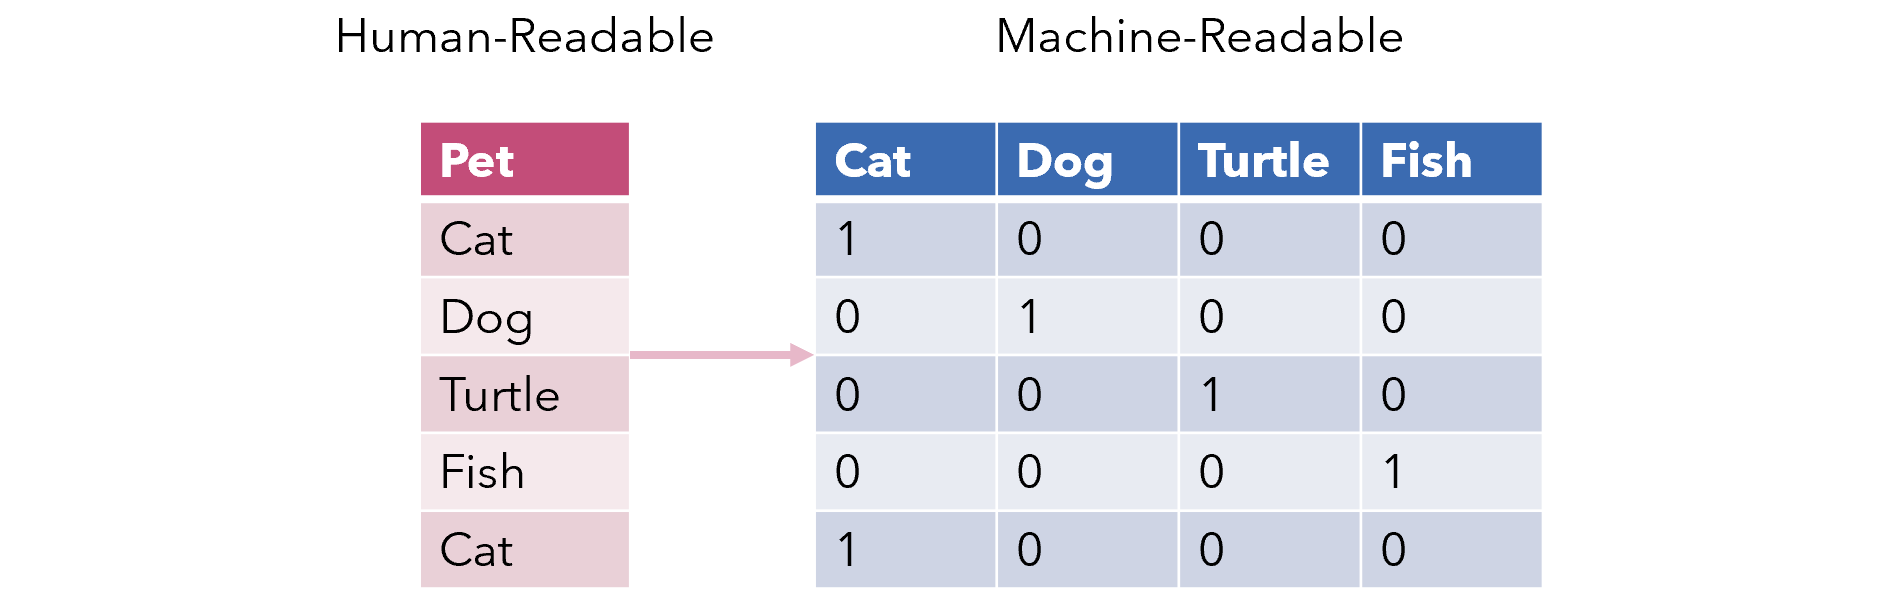

여러 개의 카테고리를 합쳐 한 개의 카테고리 one-hot vector를 만든다.

먼저 2개의 카테고리 column을 하나의 one-hot vector column을 만든다.

In [54]:
column_names = ['cat1', 'cat2']
mapper = {} # List의 인덱스를 저장할 mapper
for i, column in enumerate(column_names):
    unique_values_per_column = df_part[column].unique()
    for val in unique_values_per_column:
        unique_cat_id = val * 10 + i # 모든 카테고리에 중복되는 값이 없도록 val * 10 + i을 한다.
        mapper[unique_cat_id] = len(mapper)
mapper

{307630350: 0,
 289283660: 1,
 270937010: 2,
 252590320: 3,
 93122740: 4,
 58242330: 5,
 56429400: 6,
 1389370: 7,
 19736060: 8,
 93122741: 9,
 291960721: 10,
 74776051: 11,
 265970951: 12,
 56429401: 13,
 289283661: 14,
 58242351: 15,
 270937011: 16,
 1389371: 17,
 58242321: 18,
 252590321: 19,
 58242331: 20,
 58242371: 21,
 307630351: 22,
 324400471: 23,
 58242341: 24,
 265970961: 25,
 58242361: 26,
 19736061: 27,
 38082711: 28,
 58242391: 29,
 324400531: 30,
 324400401: 31,
 324400411: 32,
 216114141: 33,
 90682081: 34,
 239981171: 35}

In [55]:
def one_hot(values):
    v = np.zeros(len(mapper))
    for i, val in enumerate(values):
        mapped_val_id = mapper[val * 10 + i]
        v[mapped_val_id] = 1
    return v

In [60]:
df_ext = df_part.copy()
df_ext['test_col'] = df_ext[column_names].values.tolist()
df_ext['test_col'].head()

0    [30763035, 9312274]
1    [30763035, 9312274]
2    [30763035, 9312274]
3    [28928366, 9312274]
4    [30763035, 9312274]
Name: test_col, dtype: object

In [62]:
df_ext['test_col'].map(one_hot).head()

0    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: test_col, dtype: object

In [74]:
def map_one_hot(df, column_names, result_column_name):
    mapper = {}
    for i, column in enumerate(column_names):
        unique_values_per_column = df[column].unique()
        for val in unique_values_per_column:
            unique_cat_id = val * 10 + i # 모든 카테고리에 중복되는 값이 없도록 val * 10 + i을 한다.
            mapper[unique_cat_id] = len(mapper)
    def one_hot(values):
        v = np.zeros(len(mapper))
        for i, val in enumerate(values):
            mapped_val_id = mapper[val * 10 + i]
            v[mapped_val_id] = 1
        return v
    df_ext = df.copy()
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    return df_ext, mapper

In [77]:
column_names = [col for col in df_part.columns if 'cat' in col]
column_names

['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']

In [111]:
column_names = ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8']
df2, mapper_cate = map_one_hot(df_part, column_names, 'cats')

In [112]:
df3, mapper_campaigns = map_one_hot(df2, ['campaign'], 'campaigns')

In [113]:
df3.head(3)

,Unnamed: 0,Unnamed: 0.1,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,...,cat5,cat6,cat7,cat8,cat9,jid,camp_cnt,timestamp_norm,cats,campaigns
0,0,1265256,209415,21670661,10474106,1,1420115,17559949,0,1,...,11409684,30763035,8549927,29196072,29520626,21670661_17559949,7890,0.078397,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,55,7851159,1238119,3661462,10474106,1,1672978,24286866,0,1,...,11409684,28928366,8549927,29196072,29520629,3661462_24286866,7890,0.463510,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,76,9578475,1531823,8030609,10474106,1,1531964,16414421,0,1,...,11409684,32440041,8549927,29196072,9491351,8030609_16414421,7890,0.573463,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Logistic을 위해 추가 데이터 전처리

jid 1 camp [0, 1, 0], cats [1, 0, 0], timestmp 1<br>
jid 1 camp [0, 0, 1], cats [0, 1, 0], timestmp 2<br>
=> 유저별로 하나의 vector로 만들기<br>
jid 1 camp [0, 1, 1], cats [1, 1, 0]

캠페인이 여러개일 때 하나의 many-hot vector(여러개의 1이 있는 형태)로 변경 해준다.

In [114]:
def pairwise_max(series):
    return np.max(series.tolist(), axis=0).tolist()

In [115]:
series = pd.Series([[0, 1, 0], [0, 0, 1]])
pairwise_max(series)

[0, 1, 1]

In [116]:
aggregation = {
    'campaigns': pairwise_max,
    'cats': pairwise_max,
    'click': 'sum',
    'cost': 'sum',
    'conversion': 'max'
}

In [117]:
df_agg = df3.groupby('jid').agg(aggregation)

In [118]:
df_agg

,campaigns,cats,click,cost,conversion
jid,,,,,
10000148_-1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.001278,0
1000023_5282678,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.002972,1
10000403_29178244,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.000671,1
1000095_27795443,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.001216,1
10001378_24057324,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",11,0.057412,1
...,...,...,...,...,...
9999096_16958422,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.003315,1
9999669_4594367,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.000286,1
9999748_-1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,0.010167,0


In [119]:
df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()

In [120]:
df_agg['features'].head()

jid
10000148_-1          [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1000023_5282678      [[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10000403_29178244    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
1000095_27795443     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
10001378_24057324    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
Name: features, dtype: object

### numpy hstack
array를 가로로 이어준다<br>
'campaigns', 'cats', 'click', 'cost'

In [121]:
test = [[0,1,0], [1,0,0,1], 0, 0.3]
np.hstack(test)

array([0. , 1. , 0. , 1. , 0. , 0. , 1. , 0. , 0.3])

### numpy stack
array를 세로로 이어준다

In [122]:
a = np.array([1, 2])
b = np.array([3, 4])
np.stack((a, b))

array([[1, 2],
       [3, 4]])

In [123]:
x = np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values)
y = df_agg['conversion'].values

In [124]:
x.shape, y.shape

((95388, 376), (95388,))

### Dataset Splitting

In [125]:
from sklearn.model_selection import train_test_split

In [127]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)           # train-test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20) # train-validation

### Logistic Regression 학습

In [130]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [132]:
m = np.shape(x)[1]
m

376

In [134]:
model = keras.Sequential()

# 376개의 feature를 input으로 받아 단 1개의 output을 내보내는 layer 하나를 만든다.
model.add(layers.Dense(1, input_dim=m, activation='sigmoid', name='contributions'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))

score = model.evaluate(x_test, y_test)

print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
477/477 [==============================] - 3s 5ms/step - loss: 0.6025 - accuracy: 0.6982 - val_loss: 0.5006 - val_accuracy: 0.7929
Epoch 2/10
477/477 [==============================] - 2s 4ms/step - loss: 0.4935 - accuracy: 0.7923 - val_loss: 0.4731 - val_accuracy: 0.7966
Epoch 3/10
477/477 [==============================] - 3s 6ms/step - loss: 0.4745 - accuracy: 0.7954 - val_loss: 0.4602 - val_accuracy: 0.8025
Epoch 4/10
477/477 [==============================] - 3s 5ms/step - loss: 0.4599 - accuracy: 0.8016 - val_loss: 0.4518 - val_accuracy: 0.8050
Epoch 5/10
477/477 [==============================] - 2s 5ms/step - loss: 0.4546 - accuracy: 0.8051 - val_loss: 0.4465 - val_accuracy: 0.8093
Epoch 6/10
477/477 [==============================] - 2s 5ms/step - loss: 0.4492 - accuracy: 0.8078 - val_loss: 0.4423 - val_accuracy: 0.8114
Epoch 7/10
477/477 [==============================] - 2s 5ms/step - loss: 0.4399 - accuracy: 0.8125 - val_loss: 0.4389 - val_accuracy: 0.8123
Epoch 

### 각 캠페인의 기여도 계산 및 비교

In [138]:
keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()

In [139]:
keras_logreg.shape

(376,)

In [156]:
n_campaigns = 50
keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[:n_campaigns]

In [157]:
keras_logreg.shape

(50,)

In [158]:
keras_logreg

array([ 0.45367208, -1.2253634 , -0.01487619, -0.35128045, -0.558964  ,
       -0.34343275,  0.10103223, -0.2331623 , -0.13428453, -0.44852057,
       -0.08874393,  0.13499188,  0.12826683, -0.3915962 , -0.48384094,
       -0.37186974, -0.2156717 , -0.04254853,  0.04304563, -0.30267736,
       -0.39696035, -0.3660244 ,  0.00451938,  0.03250007,  0.02328214,
        0.01005359, -0.3151549 , -0.09257101, -0.4517425 , -0.3616118 ,
       -0.35377565, -0.16524085, -0.11560776,  0.18249951, -0.39541757,
        0.21808173,  0.21577494,  0.45672822, -0.19297324,  0.48614186,
        0.0940009 , -0.40157482,  0.01539779, -0.83406025, -0.06667767,
       -0.62586874, -0.03755789,  0.16425894, -0.25267506,  0.01084428],
      dtype=float32)

softmax 함수를 사용해 합을 1.0이 나오도록 함

In [159]:
from sklearn.utils.extmath import softmax

In [160]:
keras_logreg = softmax([keras_logreg]).flatten()

In [161]:
keras_logreg

array([0.03511122, 0.00655013, 0.02197647, 0.01569855, 0.0127545 ,
       0.01582223, 0.02467723, 0.01766679, 0.01950292, 0.01424389,
       0.02041163, 0.02552965, 0.02535854, 0.01507824, 0.01374957,
       0.01537863, 0.0179785 , 0.02137667, 0.02328698, 0.01648039,
       0.01499757, 0.01546879, 0.02240688, 0.02304269, 0.02283126,
       0.02253122, 0.01627603, 0.02033366, 0.01419807, 0.01553719,
       0.01565942, 0.01890843, 0.01987059, 0.02677177, 0.01502073,
       0.02774152, 0.0276776 , 0.03521869, 0.01839126, 0.03626998,
       0.02450432, 0.01492852, 0.02265196, 0.00968703, 0.02086704,
       0.01192909, 0.02148362, 0.02628787, 0.0173254 , 0.02254905],
      dtype=float32)

In [162]:
np.sum(keras_logreg)

1.0

### Baseline: Last Click Attribution Model

1) 각 캠페인마다 노출수를 센다

In [163]:
def count_by_campaign(df, n_campaigns):
    counters = np.zeros(n_campaigns)
    for campaign_one_hot in df['campaigns'].values:
        campaign_id = np.argmax(campaign_one_hot)
        counters[campaign_id] = counters[campaign_id] + 1
    return counters

In [165]:
campaign_impressions = count_by_campaign(df3, n_campaigns)
campaign_impressions

array([ 7890.,  3917.,  9387., 56151.,  2860., 39373., 29132.,  4190.,
       15714.,  5337., 31525.,  8317.,  5440.,  5931.,  6434.,  3482.,
        8113.,  5199.,  3124., 32891.,  3604.,  9364.,  3301.,  7504.,
        9742., 12954.,  4396.,  2897.,  2760.,  4397.,  8565.,  5682.,
        4946., 12164.,  3645.,  6717., 12142.,  7752.,  3014.,  2647.,
        4329.,  3108.,  2857.,  2572.,  7374.,  3427.,  2705.,  3332.,
        6211.,  2849.])

2) Conversion 전에 마지막으로 본 캠페인의 수를 센다

In [170]:
# 전환된 데이터셋
dfc = df3[df3['conversion'] == 1]

# timestamp가 max인 데이터만 가져온다
idx = dfc.groupby('jid')['timestamp_norm'].transform(max) == dfc['timestamp_norm']

# 마지막 전환일 때 각 캠페인 별로 몇번 노출되었는지 노출수를 센다
campaign_conversions = count_by_campaign(dfc[idx], n_campaigns)
campaign_conversions

array([1173.,   39.,  734., 8413.,  168., 3868., 3920.,  531., 2686.,
        376., 7052., 1990., 1292.,  567.,  816.,  369.,  638.,  456.,
        409., 4465.,  154., 1122.,  386., 1073., 1374., 1694.,  752.,
        186.,  168.,  352.,  481.,  862.,  553., 2023.,  174., 1668.,
       1546., 1310.,  528.,  601.,  482.,  312.,  606.,   70.,  571.,
        285.,  358.,  279.,  670.,  906.])

3) 캠페인 별 전환수를 캠페인 별 노출수로 나눠준다

In [171]:
lta = campaign_conversions / campaign_impressions
lta

array([0.1486692 , 0.0099566 , 0.07819325, 0.14982814, 0.05874126,
       0.09823991, 0.13455993, 0.12673031, 0.17093038, 0.07045156,
       0.22369548, 0.23926897, 0.2375    , 0.09559939, 0.12682624,
       0.10597358, 0.07863922, 0.08770917, 0.1309219 , 0.13575142,
       0.0427303 , 0.11982059, 0.11693426, 0.14299041, 0.1410388 ,
       0.13077042, 0.1710646 , 0.06420435, 0.06086957, 0.08005458,
       0.05615879, 0.15170715, 0.11180752, 0.16631042, 0.04773663,
       0.24832515, 0.12732663, 0.16898865, 0.17518248, 0.22704949,
       0.11134211, 0.1003861 , 0.21211061, 0.02721617, 0.07743423,
       0.08316312, 0.1323475 , 0.08373349, 0.10787313, 0.31800632])

4) Logistic Regression과 마찬가지로 기여도(weight)의 합이 1이 되도록 조정한다.

In [173]:
lta_sum = lta.sum()
lta_normalize = lta / lta_sum
sum(lta_normalize)

1.0000000000000002

### 그래프

In [177]:
data1 = pd.DataFrame({'attribution': keras_logreg, 'method': 'logistic', 'campaign': range(50)})
data2 = pd.DataFrame({'attribution': lta_normalize, 'method': 'last', 'campaign': range(50)})
total = pd.concat([data1, data2]).reset_index()
total

,index,attribution,method,campaign
0,0,0.035111,logistic,0
1,1,0.006550,logistic,1
2,2,0.021976,logistic,2
3,3,0.015699,logistic,3
4,4,0.012755,logistic,4
...,...,...,...,...
95,45,0.013174,last,45
96,46,0.020965,last,46
97,47,0.013264,last,47
98,48,0.017088,last,48


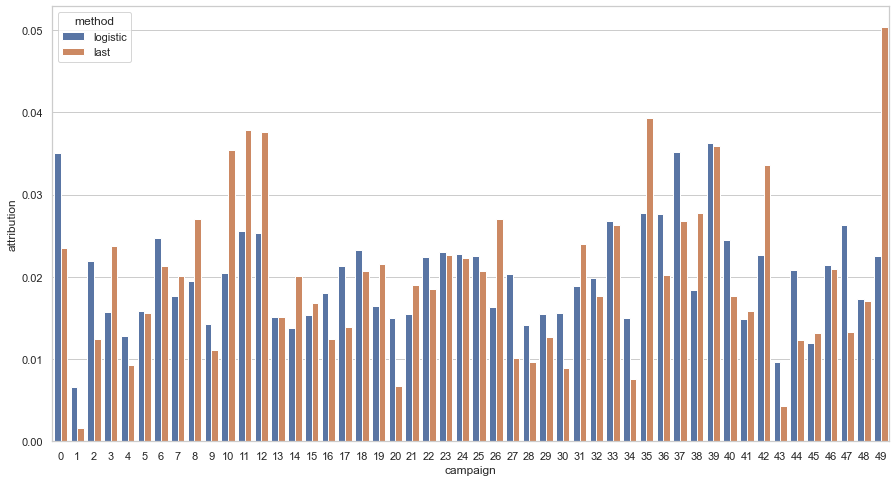

In [181]:
sns.set_theme(style='whitegrid')
g = sns.barplot(x=total.campaign, y=total.attribution, hue=total.method)
g.figure.set_size_inches(15, 8)

### 마케팅 예산 분배 시뮬레이션

* 예산을 지정한다.
* 예산을 캠페인의 기여도에 맞게 분배한다.
* 과거 유저의 전환 내역을 Replay 한다.
    * 캠페인이 노출되었다면 각 캠페인의 예산을 차감하고
    * 실제로 전환이 되었으면 전환에 +1해준다
    * 캠페인이 과거에 노출되었는데, 해당 캠페인에 대한 예산을 다 쓴 상태라면 blacklist에 넣어준다.
* 계산은 conversion - blacklist로 한다.

In [214]:
def get_campaign_id(x_journey_step, n_campaigns):
    return np.argmax(x_journey_step[:n_campaigns])

In [215]:
def simulate_budget_roi(df, n_campaigns, budget_total, attribution):
    # weight 만큼 예산을 각 캠페인에 나눈다.
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    # conversion 하지 않은 journey
    blacklist = set()
    
    # conversion이 일어난 journey
    conversions = set()
    
    for i in range(df.shape[0]):
        
        jid = df.loc[i]['jid']
        
        if jid not in blacklist:
            campaign_id = get_campaign_id(df.loc[i]['campaigns'], n_campaigns)
            
            # 캠페인에 예산이 있으면
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1

                # 전환했으면
                if df.loc[i]['conversion'] == 1:
                    conversions.add(jid)
            # 없으면 해당 jid에 대한 시뮬레이션 멈춘다
            else:
                blacklist.add(jid)
    return len(conversions.difference(blacklist))

pitch (attributions ** pitch) : 각 캠페인 별 기여도의 격차를 크게 벌릴지 작게 벌릴지! 기여도를 제곱한다.

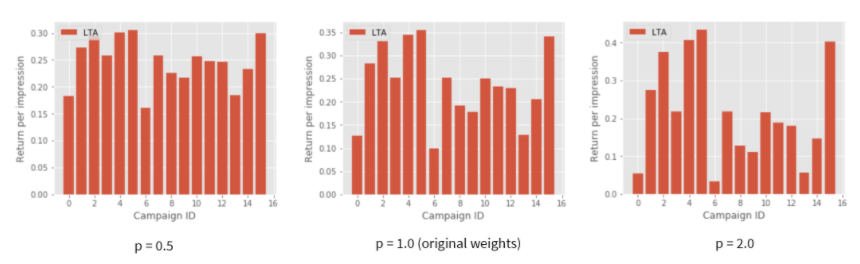

In [216]:
pitches = np.arange(0.0, 3.0, 0.5)
pitches

array([0. , 0.5, 1. , 1.5, 2. , 2.5])

데이터가 너무 크면 시뮬레이션이 오래걸리니 1만개로 제약을 둔다.

In [217]:
sample_data = df3.sample(n=10000, random_state=6666)
sample_date = sample_data.sort_values('timestamp_norm')

In [219]:
budget_total = 5000

attribution = keras_logreg

budget_logreg = []
for pitch in pitches:
    conversion = simulate_budget_roi(sample_data.reset_index(), n_campaigns, budget_total, attribution ** pitch)
    budget_logreg.append(conversion)
    print(pitch, conversion)

0.0 2012
0.5 2114
1.0 2175
1.5 2169
2.0 2109
2.5 2036


In [218]:
budget_total = 5000

attribution = lta

budget_lta = []
for pitch in pitches:
    conversion = simulate_budget_roi(sample_data.reset_index(), n_campaigns, budget_total, attribution ** pitch)
    budget_lta.append(conversion)
    print(pitch, conversion)

0.0 2012
0.5 2149
1.0 2167
1.5 2079
2.0 1972
2.5 1833


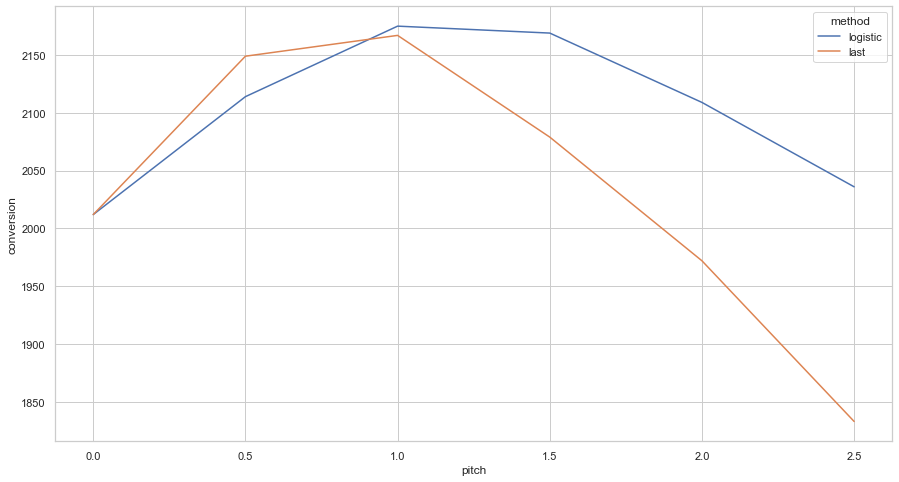

In [223]:
data1 = pd.DataFrame({'conversion': budget_logreg, 'method': 'logistic', 'pitch': pitches})
data2 = pd.DataFrame({'conversion': budget_lta, 'method': 'last', 'pitch': pitches})
total = pd.concat([data1, data2]).reset_index()

sns.set_theme(style='whitegrid')
g = sns.lineplot(x=total.pitch, y=total.conversion, hue=total.method)
g.figure.set_size_inches(15, 8)